# Adaptive Shot Allocation for Expectation Value Calculations - Part 1

## Overview
In this notebook, we'll explore how to efficiently calculate expectation values in quantum computing by intelligently allocating measurement shots (the number of times we repeat a quantum measurement). You will learn:

- Why shot allocation matters in quantum computing
- How to implement different shot allocation strategies
- How to evaluate and compare these strategies
- What makes a shot allocation strategy optimal

This is Part 1 of a two-part series on shot allocation strategies. It serves as an introdcution to the shot-allocation problem, and focuses on static allocation methods. Part 2 will cover an advanced adaptive technique and its implementation in the Braket Algorithms Libary.

## Background
In quantum computing, we often need to compute expectation values of Hamiltonian operators, which represent the average value we would get if we measured the energy of a quantum system. A Hamiltonian operator typically comes as a sum of simpler terms:

$$ \mathbf{H} = \sum_{i=1}^N c_i\mathbf{H_i} $$

where each $\mathbf{H_i}$ is a simpler operator (like a Pauli string) and $c_i$ is its coefficient. The expectation value for a quantum state $|\phi\rangle$ is then computed as:

$$ \langle\phi|\mathbf{H}|\phi\rangle = \sum_{i=1}^N c_i\langle\phi|\mathbf{H_i}|\phi\rangle $$

In other words, we calculate the expectation value for each term and then take their weighted sum.

### Why Shot Allocation Matters
In algorithms like the variational quantum eigensolver (VQE), calculating these expectation values can become computationally expensive for several reasons:

1. Real-world Hamiltonians can have thousands of terms
2. Each term requires multiple measurements ("shots") for precise estimation
3. These calculations often need to be repeated hundreds of times during optimization

With limited resources (total number of shots), we need to be smart about how we allocate these shots among different terms in order to obtain the most (statistically) accurate result. This is the shot allocation problem and, as we'll see, the answer isn't always intuitive.

## 1. The Setup
Let's start with a simple two-qubit Hamiltonian:

$$ \mathbf{H} = ZI + IZ + 10\times XX $$

where:
- $ZI$ means Pauli-Z on first qubit, Identity on second
- $IZ$ means Identity on first qubit, Pauli-Z on second
- $XX$ means Pauli-X on both qubits

For any quantum state $|\phi\rangle$, its expectation value is:

$$ \langle\phi|\mathbf{H}|\phi\rangle = \langle\phi|{ZI}|\phi\rangle + \langle\phi|{IZ}|\phi\rangle + 10\times\langle\phi|{XX}|\phi\rangle $$

If we have a fixed measurement budget (say 1200 shots), how should we distribute these shots among the three terms for the most accurate result? Let's explore this using Amazon Braket SDK.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Observable
from braket.devices import LocalSimulator

### 1.1 Preparing Our Quantum State
First, let's prepare a quantum state $|\phi\rangle$ using a typical VQE ansatz with random parameters:

In [2]:
# Create a parameterized circuit with random angles
random_state = (Circuit()
         .ry(angle = np.random.rand()*np.pi, target=0).ry(angle = np.random.rand()*np.pi, target=1)
         .cnot(control=0, target=1)
         .ry(angle = np.random.rand()*np.pi, target=0).ry(angle = np.random.rand()*np.pi, target=1)
        )

print(random_state)

T  : │     0      │  1  │     2      │
      ┌──────────┐       ┌──────────┐ 
q0 : ─┤ Ry(1.72) ├───●───┤ Ry(1.08) ├─
      └──────────┘   │   └──────────┘ 
      ┌──────────┐ ┌─┴─┐ ┌──────────┐ 
q1 : ─┤ Ry(0.81) ├─┤ X ├─┤ Ry(0.46) ├─
      └──────────┘ └───┘ └──────────┘ 
T  : │     0      │  1  │     2      │


Now let's define our Hamiltonian in terms of its Pauli strings and their coefficients:

In [3]:
# Define the different terms of the Hamiltonian as Observables
ZI = Observable.Z(0)  # Pauli-Z on first qubit
IZ = Observable.Z(1)  # Pauli-Z on second qubit
XX = Observable.TensorProduct([Observable.X(0), Observable.X(1)])  # Pauli-X on both qubits

# Define the Hamiltonian as two lists - the terms and their coefficients
paulis = [ZI, IZ, XX]
coeffs = [1.0, 1.0, 10.0]

### 1.2 Implementing Expectation Value Calculations
Below, we create two functions for expectation value calculation:

1. `compute_expectation_value_approximation`: Computes an approximation using a finite number of shots, mimicking what would happen on real quantum hardware. This function takes a quantum state and a shot configuration (how many shots to use for each term).

2. `get_exact_expectation_value`: Computes the exact expectation value using state vector simulation. This is only possible in simulation and serves as our "ground truth" for evaluating the accuracy of our approximations.

For demonstration purposes, we'll use a local quantum simulator, but the first function could run on any quantum device.

In [4]:
# Set up local simulator device
device = LocalSimulator()

def compute_expectation_value_approximation(state, shot_configuration):
    """Compute approximate expectation value using specified shot allocation.
    
    Args:
        state (Circuit): Quantum circuit representing the state
        shot_configuration (list): Number of shots for each Pauli term
    
    Returns:
        float: Approximated expectation value
    """
    assert (len(shot_configuration)==len(paulis))
    expectation_value = 0.0
    
    for i, term in enumerate(paulis):
        # Define a circuit measuring the specific term on the given state
        circuit = state.copy().sample(term)
        
        # Execute measurements and get results (±1)
        measurements = device.run(circuit, shots = shot_configuration[i]).result().values[0]
        
        # Calculate term's contribution: mean of measurements × coefficient
        expectation_value += coeffs[i]*np.mean(measurements, dtype=float)
    
    return expectation_value

In [5]:
def get_exact_expectation_value(state):
    """Compute exact expectation value using state vector simulation.
    
    Args:
        state (Circuit): Quantum circuit representing the state
    
    Returns:
        float: Exact expectation value
    """
    expectation_value = 0.0
    
    for i, term in enumerate(paulis):
        # Calculate exact expectation for each term
        circuit = state.copy().expectation(term)
        normalized_expectation = device.run(circuit, shots = 0).result().values[0]
        
        # Add term's contribution: exact expectation × coefficient
        expectation_value += coeffs[i]*normalized_expectation
    
    return expectation_value

# Calculate exact expectation value for reference
exact_expectation = get_exact_expectation_value(random_state)
print(f"Exact expectation value: {exact_expectation:.6f}")

Exact expectation value: 4.927344


## 2. Shot-Allocation Strategies
### 2.1 Uniform Shot Allocation
Let's start with the simplest approach: distributing our 1200 shots equally among the three terms. To gather some statistics on the accuracy of our estimator we perform 1000 independent evaluations and look at the deviation of the results from the mean.

In [6]:
uniform_shot_allocation = [400, 400, 400]

# Run multiple trials to get statistics
uniform_values = [compute_expectation_value_approximation(random_state, uniform_shot_allocation) for _ in range(1000)]
uniform_mean = np.mean(uniform_values)
uniform_std = np.std(uniform_values)

print(f"Uniform allocation ({uniform_shot_allocation}):\n"
      f"Mean: {uniform_mean:.6f} ± {uniform_std:.6f}")

Uniform allocation ([400, 400, 400]):
Mean: 4.917250 ± 0.396916


Let's visualize these results:

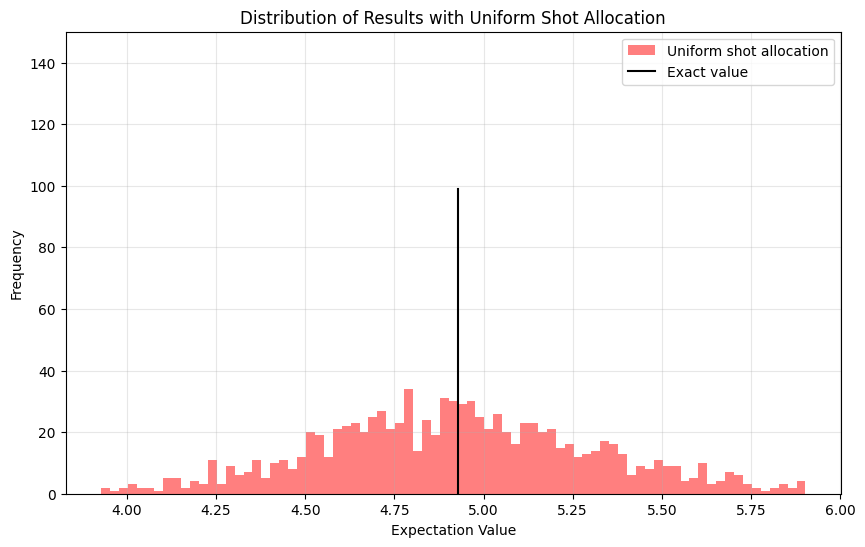

In [7]:
def plot_histograms(data, labels, colors, exact_expectation, title, y_max = 150):
    num_sets = len(data)
    assert (len(labels) == num_sets)
    assert (len(colors) == num_sets)
    
    plt.figure(figsize=(10, 6))
    for i in range(num_sets):
        plt.hist(data[i], alpha=0.5, bins=np.arange(exact_expectation-1, exact_expectation+1, 0.025),
             color=colors[i], label=labels[i])
    
    if not y_max:
        y_max = int(np.ceil(plt.ylim()[1]))
    
    plt.ylim(0,y_max)
    ev_line_height = (2*y_max//3)
    plt.plot([exact_expectation]*ev_line_height, np.arange(ev_line_height), color="black", label="Exact value")
    
    plt.xlabel("Expectation Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(title)
    plt.grid(True, alpha=0.3)

plot_histograms([uniform_values], ["Uniform shot allocation"], ["red"], exact_expectation, "Distribution of Results with Uniform Shot Allocation")

### 2.2 Coefficient-Weighted Allocation
A natural improvement might be to allocate more shots to terms with larger coefficients. After all, errors in these terms have a bigger impact on the final result.

In our Hamiltonian:
-  $ZI$ and $IZ$ have coefficients of 1.0
-  $XX$ has a coefficient of 10.0

Let's allocate shots proportionally to these coefficients:

In [8]:
weighted_shot_allocation = [100, 100, 1000]

# Run multiple trials to get statistics
weighted_values = [compute_expectation_value_approximation(random_state, weighted_shot_allocation) for _ in range(1000)]
weighted_mean = np.mean(weighted_values)
weighted_std = np.std(weighted_values)

print(f"Coefficient-weighted allocation ({weighted_shot_allocation}):\n"
      f"Mean: {weighted_mean:.6f} ± {weighted_std:.6f}")

Coefficient-weighted allocation ([100, 100, 1000]):
Mean: 4.924480 ± 0.271088


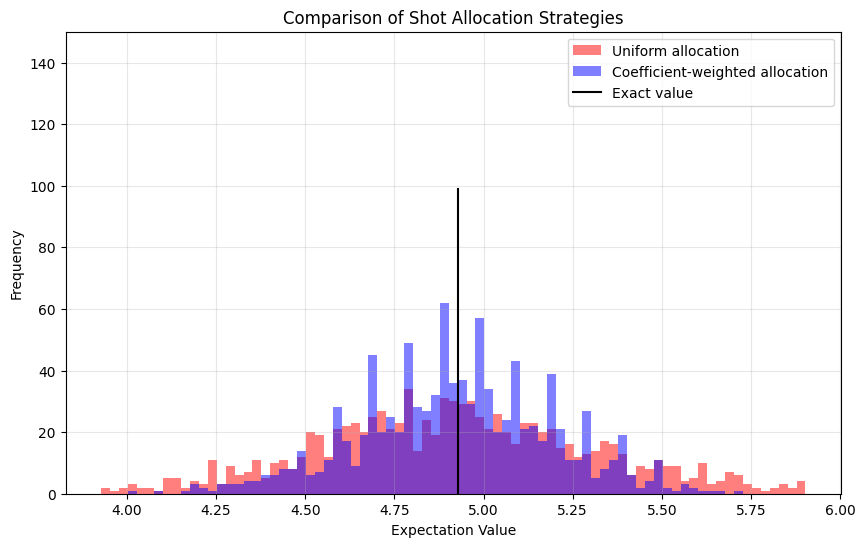

In [9]:
plot_histograms([uniform_values, weighted_values], ["Uniform allocation", "Coefficient-weighted allocation"], ["red", "blue"], 
               exact_expectation, "Comparison of Shot Allocation Strategies")

## 3. An Illustrative Example
### 3.1 Coefficient-Weighting Isn't Always Optimal
To understand why coefficient-based weighting isn't always the best strategy, let's examine a special case: the uniform superposition state.

$$ |\psi\rangle = \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle) $$

For this state, we can calculate the exact expectation values:

1. For $IZ$ (Z on second qubit):

$$ \langle \psi| IZ |\psi\rangle = \frac{1}{4}(\langle 00|00\rangle - \langle 01|01\rangle + \langle 10|10\rangle - \langle 11|11\rangle) = 0 $$

2. For $ZI$ (Z on first qubit):

$$ \langle \psi| ZI |\psi\rangle = \frac{1}{4}(\langle 00|00\rangle + \langle 01|01\rangle - \langle 10|10\rangle - \langle 11|11\rangle) = 0 $$

3. For $XX$ (X on both qubits):

$$ \langle \psi| XX |\psi\rangle = \frac{1}{4}(\langle 00|11\rangle + \langle 01|10\rangle + \langle 10|01\rangle + \langle 11|00\rangle) = 1 $$

Therefore:

$$ \langle \psi| \mathbf{H} |\psi\rangle = 1.0 \times 0 + 1.0 \times 0 + 10.0 \times 1 = 10.0 $$

Let's verify this numerically:

In [10]:
# Prepare uniform superposition state
uniform_superposition_state = Circuit().h(0).h(1)  # Apply Hadamard gates to create uniform superposition
print(uniform_superposition_state)

exact_expectation = get_exact_expectation_value(uniform_superposition_state)
print(f"Exact expectation value: {exact_expectation:.6f}")

T  : │  0  │
      ┌───┐ 
q0 : ─┤ H ├─
      └───┘ 
      ┌───┐ 
q1 : ─┤ H ├─
      └───┘ 
T  : │  0  │
Exact expectation value: 10.000000


Now let's compare our allocation strategies on this special state. Again, we use 1000 independent evaluations for each strategy to gather statistics:

In [11]:
# Compare uniform and weighted allocations
uniform_values = [compute_expectation_value_approximation(uniform_superposition_state, uniform_shot_allocation) for _ in range(1000)]
weighted_values = [compute_expectation_value_approximation(uniform_superposition_state, weighted_shot_allocation) for _ in range(1000)]

print(f"Uniform allocation ({uniform_shot_allocation}):\n"
      f"Mean: {np.mean(uniform_values):.6f} ± {np.std(uniform_values):.6f}\n")

print(f"Coefficient-weighted allocation ({weighted_shot_allocation}):\n"
      f"Mean: {np.mean(weighted_values):.6f} ± {np.std(weighted_values):.6f}")

Uniform allocation ([400, 400, 400]):
Mean: 9.999780 ± 0.071970

Coefficient-weighted allocation ([100, 100, 1000]):
Mean: 9.998860 ± 0.143964


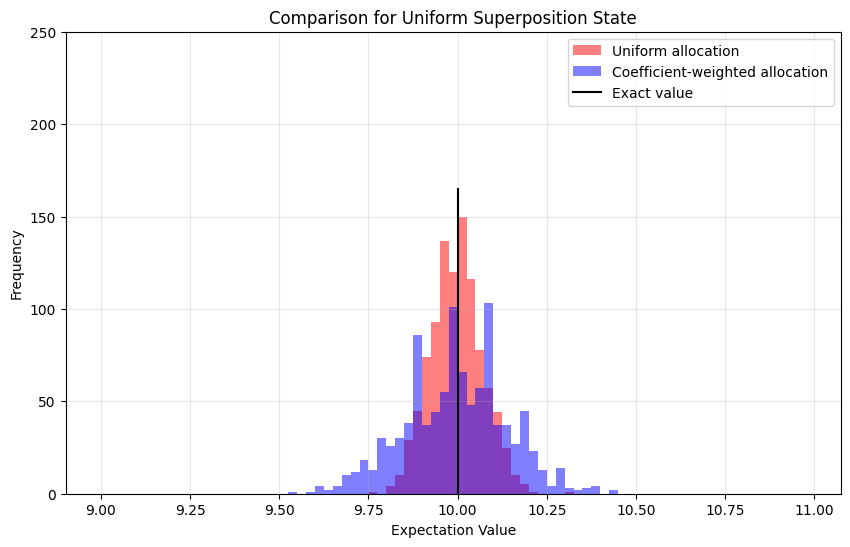

In [12]:
plot_histograms([uniform_values, weighted_values], ["Uniform allocation", "Coefficient-weighted allocation"], ["red", "blue"], 
               exact_expectation, "Comparison for Uniform Superposition State", y_max = 250)

#### Interpreting the Results
For the uniform superposition state, the coefficient-weighted allocation performs significanly worse! Why?

The uniform superposition state is an eigenstate of the $XX$ operator with eigenvalue +1. This means:
1. Every measurement of $XX$ will give exactly +1
2. We only need a single shot to determine $\langle XX \rangle$ perfectly
3. Additional shots on $XX$ are wasted - they could be better used measuring $ZI$ and $IZ$

This demonstrates why considering only coefficients Hamiltonian isn't enough - whenever possible, we also need to take into account the variance of our measurements on the particular state we're working with.

### 3.2 Optimal Shot Allocation (for our particular case)
For independently measured terms, the optimal strategy allocates shots proportionally to

$$ |c_i|\sqrt{\mathbb{Var}(\mathbf{P}_i)}, $$

where:
- $c_i$ is the coefficient;
- $\mathbb{Var}(\mathbf{P}_i) = 1-\langle\phi|\mathbf{P}_i|\phi\rangle^2$ is the variance of measurements.

For our uniform superposition state:
- $XX$ has zero variance (it's an eigenstate)
- $ZI$ and $IZ$ have maximum variance

Therefore, the optimal strategy uses just one shot for $XX$ and splits the remaining shots between $ZI$ and $IZ$:

In [13]:
optimal_shot_allocation = [600, 599, 1]

optimal_values = [compute_expectation_value_approximation(uniform_superposition_state, optimal_shot_allocation) for _ in range(1000)]
optimal_mean = np.mean(optimal_values)
optimal_std = np.std(optimal_values)

print(f"Optimal allocation ({optimal_shot_allocation}):\n"
      f"Mean: {optimal_mean:.6f} ± {optimal_std:.6f}")

Optimal allocation ([600, 599, 1]):
Mean: 10.002361 ± 0.057187


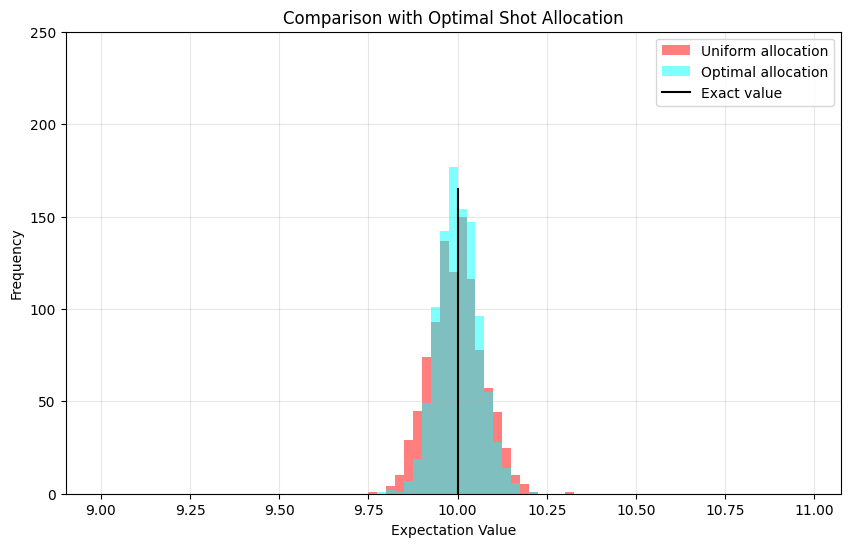

In [14]:
plot_histograms([uniform_values, optimal_values], ["Uniform allocation", "Optimal allocation"], ["red", "cyan"], 
               exact_expectation, "Comparison with Optimal Shot Allocation", y_max = 250)

### 3.3 Further Optimization: Grouping Compatible Measurements
We can do even better! Notice that $IZ$ and $ZI$ commute - they can be measured simultaneously in the computational basis. As Braket supports simultaneous measurements of qubitwise commuting observables, we can sample both $IZ$ and $ZI$ in a single shot.

Let's implement this optimization:

In [15]:
def compute_grouped_expectation_value_approximation(state, observable_index_groups, shot_configuration):
    """Compute expectation value using grouped measurements where possible.
    
    Args:
        state (Circuit): Quantum circuit representing the state
        observable_index_groups (list): Groups of observable indices that can be measured together
        shot_configuration (list): Number of shots for each group
    
    Returns:
        float: Approximated expectation value
    """
    assert (len(shot_configuration)==len(observable_index_groups))
    expectation_value = 0.0
    
    for i, group in enumerate(observable_index_groups):
        if isinstance(group, int):  # Allow single indices to be passed directly
            group = [group]
        
        # Set up circuit to measure all observables in this group
        circuit = state.copy()
        for term in group:
            circuit.sample(paulis[term])
        
        # Get measurements for all observables in the group
        measurements = device.run(circuit, shots = shot_configuration[i]).result().values
        
        # Process each observable's measurements
        for idx_in_group, idx_global in enumerate(group):
            expectation_value += coeffs[idx_global]*np.mean(measurements[idx_in_group], dtype=float)
    
    return expectation_value

In [16]:
# Group ZI and IZ together, measure XX separately
grouped_optimal_values = [compute_grouped_expectation_value_approximation(uniform_superposition_state, [[0,1], 2], [1199, 1]) 
                         for _ in range(1000)]

grouped_mean = np.mean(grouped_optimal_values)
grouped_std = np.std(grouped_optimal_values)

print(f"Grouped optimal allocation ([1199, 1] shots for [[ZI,IZ], XX]):\n"
      f"Mean: {grouped_mean:.6f} ± {grouped_std:.6f}")

Grouped optimal allocation ([1199, 1] shots for [[ZI,IZ], XX]):
Mean: 9.999393 ± 0.040823


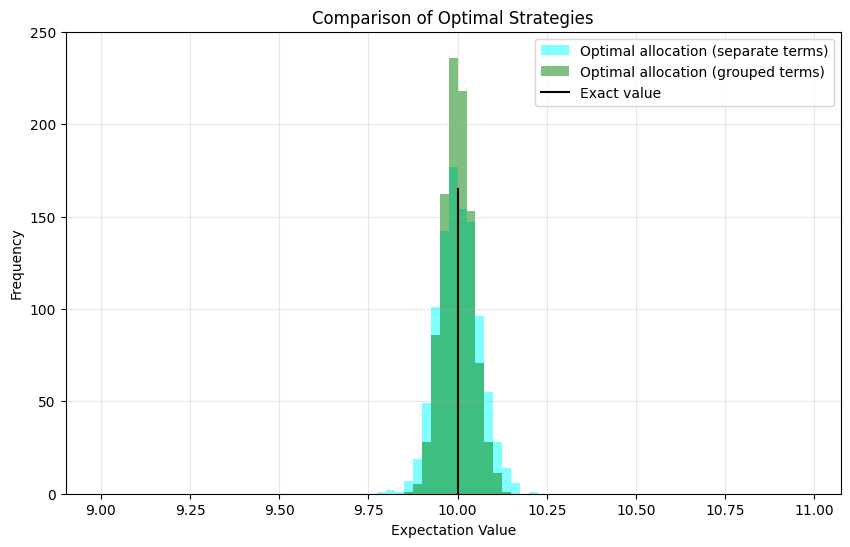

In [17]:
plot_histograms([optimal_values, grouped_optimal_values], ["Optimal allocation (separate terms)", "Optimal allocation (grouped terms)"],
                ["cyan", "green"], exact_expectation, "Comparison of Optimal Strategies", y_max = 250)

We should note that, while grouping the terms will not do worse than measuring them separately, it is not always guaranteed to improve the accuracy of our estimator. As an example, one can run the experiment above on the Bell state $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$ (we leave this as an exercise). In that case, due to the perfect correlation of the $IZ$ and $ZI$ measurements, no extra information can be gained by grouping, and there will be no difference in the performance of the grouped- and separate- measurement strategies. 

## 4. Conclusion
### 4.1 Key Takeaways

1. **Shot Allocation Matters**: How we distribute measurement shots can significantly impact the accuracy of our results.

2. **Simple Strategies Aren't Always Best**:
   - Uniform allocation ignores term importance
   - Coefficient-based weighting can be misleading

3. **Optimal Strategy Considers**:
   - Term coefficients
   - Measurement variance
   - Possibility of grouping compatible measurements

### 4.2 Preview of Part 2
In Part 2 of this series, we will address a fundamental challenge: in real applications, we don't know the measurement variances beforehand, so we can't determine the optimal shot allocation strategy upfront. We'll implement an adaptive shot allocation approach that dynamically learns and adjusts as measurements are taken.

Below is a quick preview demonstrating how the accuracy of this adaptive approach can rival even the optimal strategy (which, of course, is generally not known to us beforehand). The adaptive method achieves this by starting with an initial allocation and then refining it based on the measurement results it observes.

In [18]:
from braket.experimental.algorithms.adaptive_shot_allocation.adaptive_allocator import AdaptiveShotAllocator
from braket.experimental.algorithms.adaptive_shot_allocation.adaptive_allocator_braket_helpers import (
    run_fixed_allocation, 
    run_adaptive_allocation
)
from tqdm.notebook import tqdm

estimator = AdaptiveShotAllocator(['IZ', 'ZI', 'XX'], [1.0, 1.0, 10.0])

adaptive_values = []

for _ in tqdm(range(1000)):
    estimator.reset()

    adaptive_values.append(estimator.expectation_from_measurements(
            run_adaptive_allocation(device, uniform_superposition_state, estimator, 100, 12)
        )
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

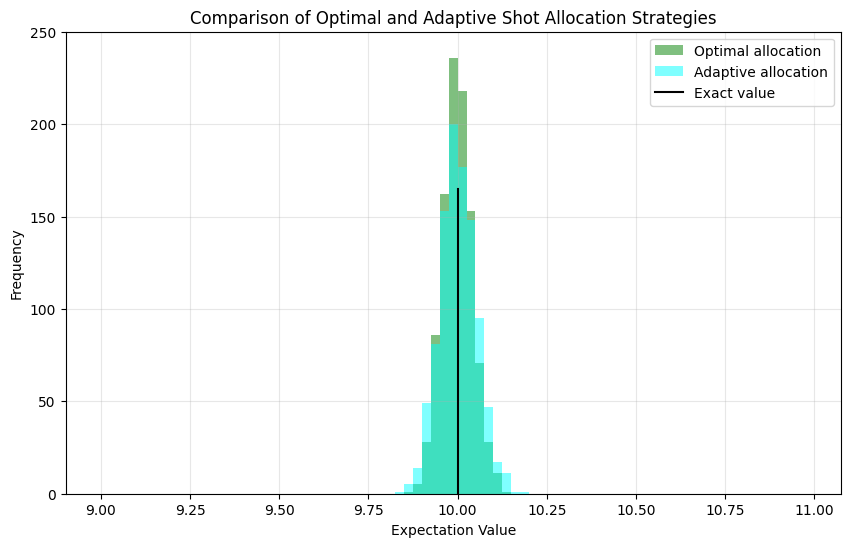

In [19]:
plot_histograms([grouped_optimal_values, adaptive_values], ["Optimal allocation", "Adaptive allocation"], ["green", "cyan"], 
               exact_expectation, "Comparison of Optimal and Adaptive Shot Allocation Strategies", y_max = 250)